# Рекомендация  тарифов "Смарт" и "Ультра" оператора "Мегалайн"

Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
<br>В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Проверку данных и все процедуры предобработки я все равно решила провести, чтобы структура проекта была полной.
<br> После проверки данных, разделим их на 3 выборки: тренировочную, валидационную и тестовую. 
<br> Запустим 3 модели с вариациями гиперпараметров: решающее дерево, случайный лес и логическая регрессия. 
<br> Рассчитаем accuracy по валидационным и тестовым выборкам.
<br> Проверим адекватность моделей с помощью DummyClassifier.

## Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter('always', FitFailedWarning)

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В файле 5 столбцов. Содержатся сведения о кол-ве звонков - столбец calls, минутах разговора - столбец minutes, кол-ве сообщений - messages, объеме трафика mb_used bи колонка is_ultra. Вероятно, что 1 - пользователь тарифа Ultra, 0- пользователь тарифа Smart(это мы проверим).
<br> Приступим к предобработке данных.

## Предобработка данных

### Проверка названий столбцов

Проверим как называются столбцы.

In [4]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

Названия столбцов корректрые.Корректировка не требуется. 

###  Проверка типов данных

Посмотрим на типы данных.

In [5]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В выборке 5 столбцов. Во всех столбцах, кроме последнего, значения вещественные float. Типы данных верные.Посмотрим значения в столбце is_ultra.

In [6]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Значения is_ultra принимают значения 0 или 1. Т.е. 1 - пользователь тарифа ultra. 0 - пользователь тарифа smart.

### Проверка на пропуски.

In [7]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Отлично. Пропусков в данных нет.

### Проверка дубликатов.

In [8]:
df.duplicated().sum()

0

Отлично. Дубликатов в данных нет.

### Аномалии в данных.

Для начала, посмотрим на данные методом describe().

In [9]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


В данных нет отрицательных значений, т.к. мин значения - 0. Уже хорошо.
<br> Посмотрим на данные более детально. Построим гистограммы значений.

calls


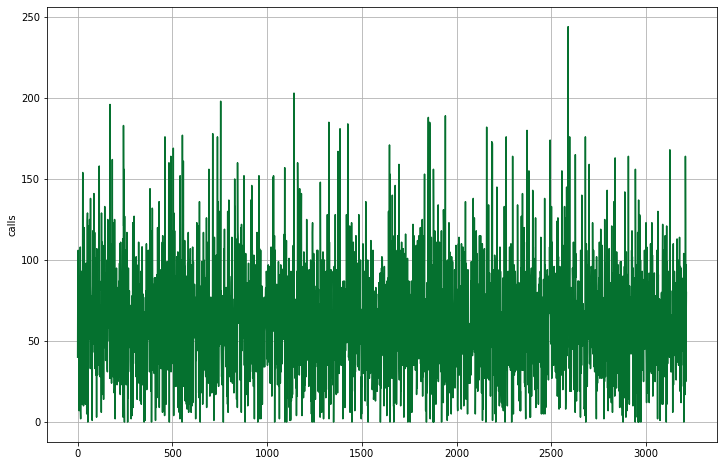

minutes


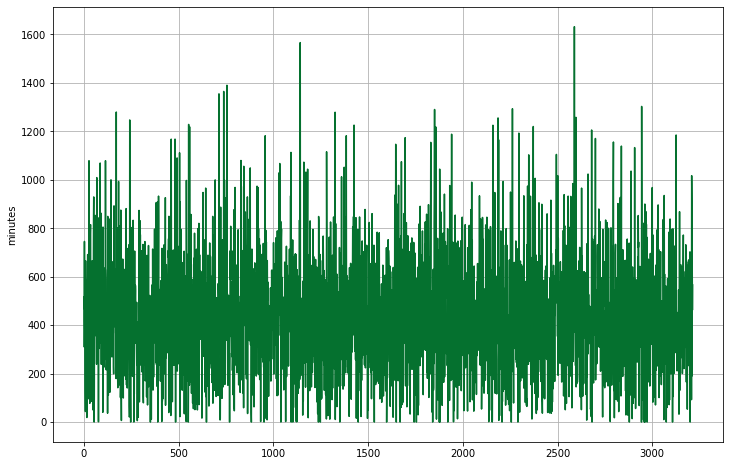

messages


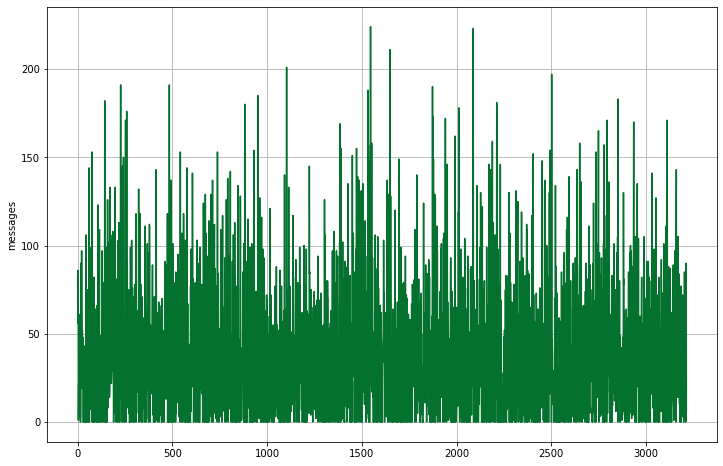

mb_used


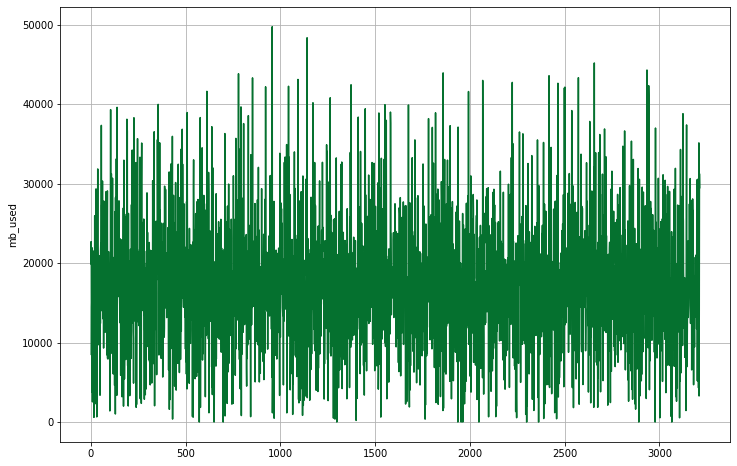

is_ultra


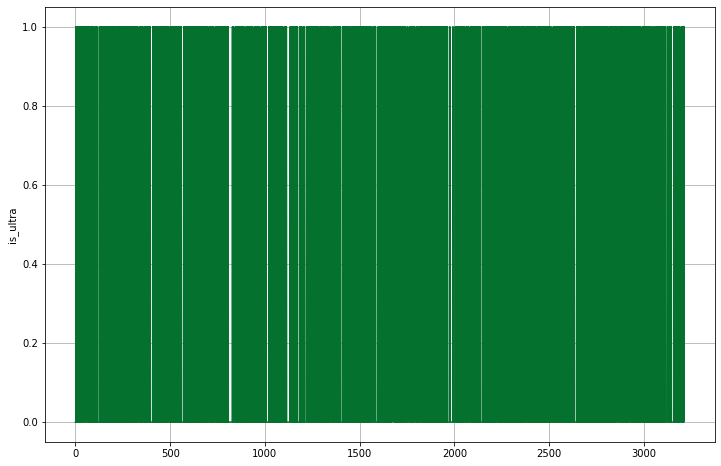

In [10]:
columns =['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']
for column in columns:
    print(column)
    plt.figure(figsize=(12,8))
    sns.set_palette('BuGn_r')
    sns.lineplot(data=df[column])   
    plt.grid()
    plt.show()

Пробелы видим только по is_ultra.Но там все логично. 0 и 1. По остальным столбца, кажется, что все в порядке.

Приступим к следующему шагу.

    
<div class="alert alert-block alert-success">
<b>Комментарий ревьюера👍:</b> Хорошо, можем двигаться дальше, молодец, что провела подробный EDA
</div>

## Разделение данных на обучающую, валидационную и тестовую выборки.

Разделим выборки в след соотношение от общих данных: 
<br>60% пойдет в обучающую выборку. И по 20% от всех данных в валидационную и тестовую.

Проведем разделение в 2 этапа. Разделим данные на обучающие и те, что пойдут на тестовую и обучающие выборки. Следующим этапом разделим тестовые и обучаюшие.

In [11]:
df_train, df_v_t = train_test_split(df, test_size=0.4, random_state=12345) 

In [12]:
df_valid, df_test = train_test_split(df_v_t, test_size=0.5, random_state=12345) 

Проверим, что у нас получилось.

In [13]:
print(len(df_train)/len(df),len(df_valid)/len(df),len(df_test)/len(df))

0.5998755444928439 0.2000622277535781 0.2000622277535781


    
<div class="alert alert-block alert-success">
<b>Комментарий ревьюера👍:</b> Разделение на выборки произведено корректно в пропорции 3:1:1
</div>

Целевой параметр это is_ultra. Задача Классификации, так как целевой параметр категориальный. 0 - тариф Smart. 1 -тариф Ultra. Необходимо построить модель  с максимально большим значением accuracy. Доля правильных ответов должна быть по крайней мере до 0.75. 
<br> Будем проверять так:
<br> 1.Модель решающего дерева
<br> 2.Модель случайного леса
<br> 3.Модель логической регрессии

Зададим переменные для признаков и целевого признака тестовой и валидационной выборок.

In [14]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

## Модель решающего дерева 

Проверим модель DecisionTreeClassifier. Обучим ее методом fit(). Сформируем предсказание методом predict(). И проверим accuracy модели с помощью accuracy_score.
<br>Для проверки гиперпараметров запустим цикл по max_depth. 
<br>В лучшую медель загрузим данные тестовой выборки и рассчитаем Accuracy для тестовой выборки.

In [15]:
best_model = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions) 
    if result > best_result:
        best_model = model
        best_result = result
        
print("Accuracy наилучшей модели DecisionTreeClassifier на валидационной выборке:", best_result)
print("Лучшая модель:", best_model)

Accuracy наилучшей модели DecisionTreeClassifier на валидационной выборке: 0.7853810264385692
Лучшая модель: DecisionTreeClassifier(max_depth=3, random_state=12345)


**Вывод по результатам на валидационной выборке** В ходе цикла по глубинам, мы получили максимум по точности при глубине = 3. Далее, видимо, модель уже переобучается. 

Посмотрим на результат DecisionTreeClassifier по тестовой выборке. 

In [16]:
result_test_tree = best_model.score(features_test,target_test)
print("Accuracy наилучшей модели DecisionTreeClassifier на тестовой выборке:", result_test_tree) 

Accuracy наилучшей модели DecisionTreeClassifier на тестовой выборке: 0.7791601866251944


**Вывод по результатам на тестовой выборке** Разница между результати, конечно, есть но она не большая. Значит все в порядке.

## Модель случайного леса

Проверим модель RandomForestClassifier. Обучим ее методом fit(). И проверим accuracy модели с помощью score(predict она запустит сама).
<br>Для проверки гиперпараметров запустим цикл по n_estimators.
<br>В лучшую медель загрузим данные тестовой выборки и рассчитаем Accuracy для тестовой выборки.

In [17]:
best_model = None
best_result = 0
for est in range(1, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train,target_train) 
    result = model.score(features_valid,target_valid)
    if result > best_result:
        best_model = model
        best_result = result
print("Accuracy наилучшей модели RandomForestClassifier на валидационной выборке:", best_result) 
print("Лучшая модель:", best_model)

Accuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.7822706065318819
Лучшая модель: RandomForestClassifier(n_estimators=8, random_state=12345)


Посмотрим на результат RandomForestClassifier по тестовой выборке. 

In [18]:
result_test_forest = best_model.score(features_test,target_test)
print("Accuracy наилучшей модели RandomForestClassifier на тестовой выборке:", result_test_forest) 

Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.7869362363919129


### Модель случайного леса RandomizedSearchCV

Для вариаций гиперпараметров попробуем использовать RandomizedSearchCV.

In [19]:
model_params = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
clf = RandomForestClassifier()

In [20]:
rand = RandomizedSearchCV(clf, model_params, cv=5)
rand.fit(features_train,target_train)
rand.best_params_

{'n_estimators': 40,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 9}

In [21]:
result_rand_test = rand.score(features_train,target_train)
print("Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на тренировочной выборке:", result_rand_test) 
result_rand_valid = rand.score(features_valid,target_valid)
print("Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на валидационной выборке:", result_rand_valid) 
result_rand_test = rand.score(features_test,target_test)
print("Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на тестовой выборке:", result_rand_test) 

Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на тренировочной выборке: 0.8630705394190872
Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на валидационной выборке: 0.7916018662519441
Accuracy наилучшей модели RandomForestClassifier c помощью RandomizedSearchCV на тестовой выборке: 0.80248833592535


### Модель случайного леса GridSearchCV

Для вариаций гиперпараметров попробуем использовать GridSearchCV.

In [22]:
model_params = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
clf = RandomForestClassifier()
grid = GridSearchCV(clf, model_params, cv=5)

In [23]:
grid.fit(features_train,target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [24]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 20}

In [25]:
result_grid_test = grid.score(features_train,target_train)
print("Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на тренировочной выборке:", result_grid_test) 
result_grid_valid = grid.score(features_valid,target_valid)
print("Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на валидационной выборке:", result_grid_valid) 
result_grid_test = grid.score(features_test,target_test)
print("Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на тестовой выборке:", result_grid_test) 

Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на тренировочной выборке: 0.8558091286307054
Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на валидационной выборке: 0.8009331259720062
Accuracy наилучшей модели RandomForestClassifier c помощью GridSearchCV на тестовой выборке: 0.8009331259720062


**Вывод по результатам на валидационной выборке** В ходе цикла по эстиматорам, мы получили максимум по точности при глубине = 8. Далее, видимо, модель уже переобучается.

**Вывод по результатам на тестовой выборке** Разница между результати, конечно, есть но она не большая. Значит все в порядке.

## Модель логической регрессии

Проверим модель LogisticRegression. Обучим ее методом fit(). И проверим accuracy модели с помощью score(predict она запустит сама).
<br>Для проверки гиперпараметров запустим цикл по max_iter.
<br>Также сделаем цикл по solver. В доке указаны следующие значения ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’. Только по 2м: 'lbfgs' и 'liblinear' удалось запустить рабочую модель. Их и включим в цикл.
<br>В лучшую медель загрузим данные тестовой выборки и рассчитаем Accuracy для тестовой выборки.

In [26]:
best_model = None
best_result = 0

solvers = ['lbfgs','liblinear']
for iters in range(100, 1000):
        for solv in solvers:
            model = LogisticRegression(random_state=12345, solver=solv, max_iter=iters) 
            model.fit(features_train,target_train) 
            result = model.score(features_valid,target_valid)
            if result > best_result:
                best_model = model
                best_result = result
                solv_best=solv
                iter_best=iters
print("Accuracy наилучшей модели LogisticRegression на валидационной выборке:", best_result) 
print(f"Лучшая модель: {best_model},solver= {solv_best},max_iter={iter_best}")

Accuracy наилучшей модели LogisticRegression на валидационной выборке: 0.7107309486780715
Лучшая модель: LogisticRegression(random_state=12345),solver= lbfgs,max_iter=100


**Вывод по результатам на валидационной выборке** В ходе цикла по solvers, мы получили максимум по точности при глубине liblinear. 

Посмотрим на результат LogisticRegression по тестовой выборке. 

In [27]:
result_test_regress = best_model.score(features_test,target_test)
print("Accuracy наилучшей модели LogisticRegression на тестовой выборке:", result_test_regress) 

Accuracy наилучшей модели LogisticRegression на тестовой выборке: 0.6842923794712286


**Вывод по результатам на тестовой выборке** Разница между результати, конечно, есть но она не большая. Значит все в порядке.

Выведем результаты по всем моделям.

In [28]:
print('Accuracy наилучшей модели DecisionTreeClassifier на тестовой выборке:',result_test_tree)
print('Accuracy наилучшей модели RandomForestClassifier на тестовой выборке:',result_test_forest)
print('Accuracy наилучшей модели LogisticRegression на тестовой выборке:',result_test_regress)

Accuracy наилучшей модели DecisionTreeClassifier на тестовой выборке: 0.7791601866251944
Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.7869362363919129
Accuracy наилучшей модели LogisticRegression на тестовой выборке: 0.6842923794712286


**Общий вывод**
<br>Получается, что наибольшая точность модели у нас по модели случайного леса RandomForestClassifier.
<br>В ходе цикла подобрано максимальное значение эстиматора(кол-ва деревьев):n_estimators=8.
<br>Не так далено по точности модель решающего дерева DecisionTreeClassifier. 
<br>В ходе цикла подобрано максимальное значение глубины :Значения глубины max_depth=3. 
<br> А вот с моделью логической регрессии LogisticRegression не все так хорошо. 
<br>Она явно не дотягивает до необходимого значения accurace 0.75. 
<br>Даже с учетом того, что тут была возможность подобрать 2 гиперпараметра:solvers и max_iter. 

## Проверка модели на адекватность

Адекватность модели проверим с помощью DummyClassifier. Посмотрим, какие значения он нам выдаст.

In [29]:
dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)
print('Unique predicted labels: ', (np.unique(dummy_pred)))
print('Test score: ', accuracy_score(target_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.6842923794712286


Полученное значение точности прогноза значительно ниже на DummyClassifier,чем полученное нами на моделях РД, СЛ и  ЛР. Значит, наша работа проделана не даром. 